# 시계열 예측

- 시계열 값의 미래 예측 (time series forecasting)
 - 수요예측, 매출예측, 생산/물류/재고 예측, 리스크/장애/이상 예측 등
 
## 접근법
- (1) 자신의 과거 값만 사용하여 미래 값을 예측하는 (y-y 모델)
  - 선형예측, ARIMA, Prophet 등 수리 모델 기반의 단변수 예측 모델 사용
  - 랜덤한 성분은 예측이 안된다 (트렌드, 주기성 만 예측 가능)
- (2) 다양한 외부 특성들을 사용하여 예측하는 (X-y 모델)
  - y에 영향을 주는 다양한 환경 변수들을 입력 특성 X에 포함한다
  - X에 y의 과거 값들도 포함시킬 수 있다 (위의 1을 포함하는 셈!)
  - 입력 X에 변형된 특성을 추가할 수 있다 (이동 평균, 이동 분산 등)
  - 카테고리 변수들이 많으면 X-y 모델이 잘 동작한다 (선형계열 모델은 카테고리 변수를 표현하는데 한계가 있다)
  - 임의의 머신러닝 모델을 사용할 수 있다
- (3) 샘플(행) 단위로 예측하는 것이 아니라 입력신호의 누적 효과(여러 행)를 반영하는 경우
  - 신경망 모델, LSTM을 사용한다
  - 좋은 성능을 얻으려면 학습 데이터가 충분히 많아야 한다

## X-y 모델 사용

# import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error,r2_score  
from datetime import datetime
%config InlineBackend.figure_format = 'retina'
import matplotlib

# 데이터 
- 서울 자전거 대여수 예측

- Date : year-month-day
- Rented Bike count - Count of bikes rented at each hour
- Hour - Hour of he day
- Temperature-Temperature in Celsius
- Humidity - %
- Windspeed - m/s
- Visibility - 10m
- Dew point temperature - Celsius
- Solar radiation - MJ/m2
- Rainfall - mm
- Snowfall - cm
- Seasons - Winter, Spring, Summer, Autumn
- Holiday - Holiday/No holiday
- Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/SeoulBikeData.csv",
                header=None)
print(df.shape)
df[:3]

(8760, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


In [3]:
# 컬럼 정보가 미리 주어져 있으므로 이를 사용하겠다

df.columns = ['date', 'count', 'hour', 'temp', 'humidity',
       'wind', 'visibility', 'dew',
       'solar', 'rainfall', 'snowfall', 'seasons',
       'holiday', 'functioning']

In [4]:
df[:3]

,date,count,hour,temp,humidity,wind,visibility,dew,solar,rainfall,snowfall,seasons,holiday,functioning
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


In [5]:
df.isnull().sum()

date           0
count          0
hour           0
temp           0
humidity       0
wind           0
visibility     0
dew            0
solar          0
rainfall       0
snowfall       0
seasons        0
holiday        0
functioning    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         8760 non-null   object 
 1   count        8760 non-null   int64  
 2   hour         8760 non-null   int64  
 3   temp         8760 non-null   float64
 4   humidity     8760 non-null   int64  
 5   wind         8760 non-null   float64
 6   visibility   8760 non-null   int64  
 7   dew          8760 non-null   float64
 8   solar        8760 non-null   float64
 9   rainfall     8760 non-null   float64
 10  snowfall     8760 non-null   float64
 11  seasons      8760 non-null   object 
 12  holiday      8760 non-null   object 
 13  functioning  8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ KB


## datetime 분해

In [7]:
# date 컬럼이 현재 문자열로 되어 있는데 이를 datetime 특수변수 형태로 바꾼다
# 연월일 시분초 정보를 각각 포함하고 있는 특수변수임

df.loc[:,"date"] = pd.to_datetime(df.date, dayfirst=True)
df[:3]

,date,count,hour,temp,humidity,wind,visibility,dew,solar,rainfall,snowfall,seasons,holiday,functioning
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


In [8]:
# date 컬럼의 타입이 바뀐 것을 확인한다

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         8760 non-null   datetime64[ns]
 1   count        8760 non-null   int64         
 2   hour         8760 non-null   int64         
 3   temp         8760 non-null   float64       
 4   humidity     8760 non-null   int64         
 5   wind         8760 non-null   float64       
 6   visibility   8760 non-null   int64         
 7   dew          8760 non-null   float64       
 8   solar        8760 non-null   float64       
 9   rainfall     8760 non-null   float64       
 10  snowfall     8760 non-null   float64       
 11  seasons      8760 non-null   object        
 12  holiday      8760 non-null   object        
 13  functioning  8760 non-null   object        
dtypes: datetime64[ns](1), float64(6), int64(4), object(3)
memory usage: 958.2+ KB


In [9]:
# 날짜 정보의 최소, 최대 값을 확인

df.date.min(), df.date.max()

(Timestamp('2017-12-01 00:00:00'), Timestamp('2018-11-30 00:00:00'))

In [10]:
# 혹시 중간에 빠진 날자가 있는지 확인하는 방법

pd.date_range(start = '2017-12-01', end = '2018-11-29' ).difference(df.date)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

## datetime 날짜 데이터 분해

- 시간 정보는 이미 컬럼에 있으므로 따로 추가하지 않는다

In [11]:
df["d-year"] = df["date"].dt.year
df["d-month"] = df["date"].dt.month
df["d-day"] = df["date"].dt.day
df["d-dayofweek"] = df["date"].dt.dayofweek

df[:3]

,date,count,hour,temp,humidity,wind,visibility,dew,solar,rainfall,snowfall,seasons,holiday,functioning,d-year,d-month,d-day,d-dayofweek
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,1,4
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,1,4
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,1,4


In [12]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,8750,8751,8752,8753,8754,8755,8756,8757,8758,8759
date,2017-12-01 00:00:00,2017-12-01 00:00:00,2017-12-01 00:00:00,2017-12-01 00:00:00,2017-12-01 00:00:00,2017-12-01 00:00:00,2017-12-01 00:00:00,2017-12-01 00:00:00,2017-12-01 00:00:00,2017-12-01 00:00:00,...,2018-11-30 00:00:00,2018-11-30 00:00:00,2018-11-30 00:00:00,2018-11-30 00:00:00,2018-11-30 00:00:00,2018-11-30 00:00:00,2018-11-30 00:00:00,2018-11-30 00:00:00,2018-11-30 00:00:00,2018-11-30 00:00:00
count,254,204,173,107,78,100,181,460,930,490,...,761,768,837,1047,1384,1003,764,694,712,584
hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
temp,-5.2,-5.5,-6.0,-6.2,-6.0,-6.4,-6.6,-7.4,-7.6,-6.5,...,7.8,7.0,7.2,6.0,4.7,4.2,3.4,2.6,2.1,1.9
humidity,37,38,39,40,36,37,35,38,37,27,...,20,20,23,29,34,34,37,39,41,43
wind,2.2,0.8,1.0,0.9,2.3,1.5,1.3,0.9,1.1,0.5,...,2.2,3.3,1.5,2.1,1.9,2.6,2.3,0.3,1.0,1.3
visibility,2000,2000,2000,2000,2000,2000,2000,2000,2000,1928,...,2000,1994,1945,1877,1661,1894,2000,1968,1859,1909
dew,-17.6,-17.6,-17.7,-17.6,-18.6,-18.7,-19.5,-19.3,-19.8,-22.4,...,-13.8,-14.4,-12.6,-10.7,-9.8,-10.3,-9.9,-9.9,-9.8,-9.3
solar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.23,...,1.67,1.21,0.72,0.23,0.0,0.0,0.0,0.0,0.0,0.0
rainfall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# 카테고리 변수를 원핫 인코딩한다

df = pd.get_dummies(df, ['seasons','holiday', 'functioning'])

## 카테고리 변수별 통계 보기

<AxesSubplot:xlabel='hour', ylabel='count'>

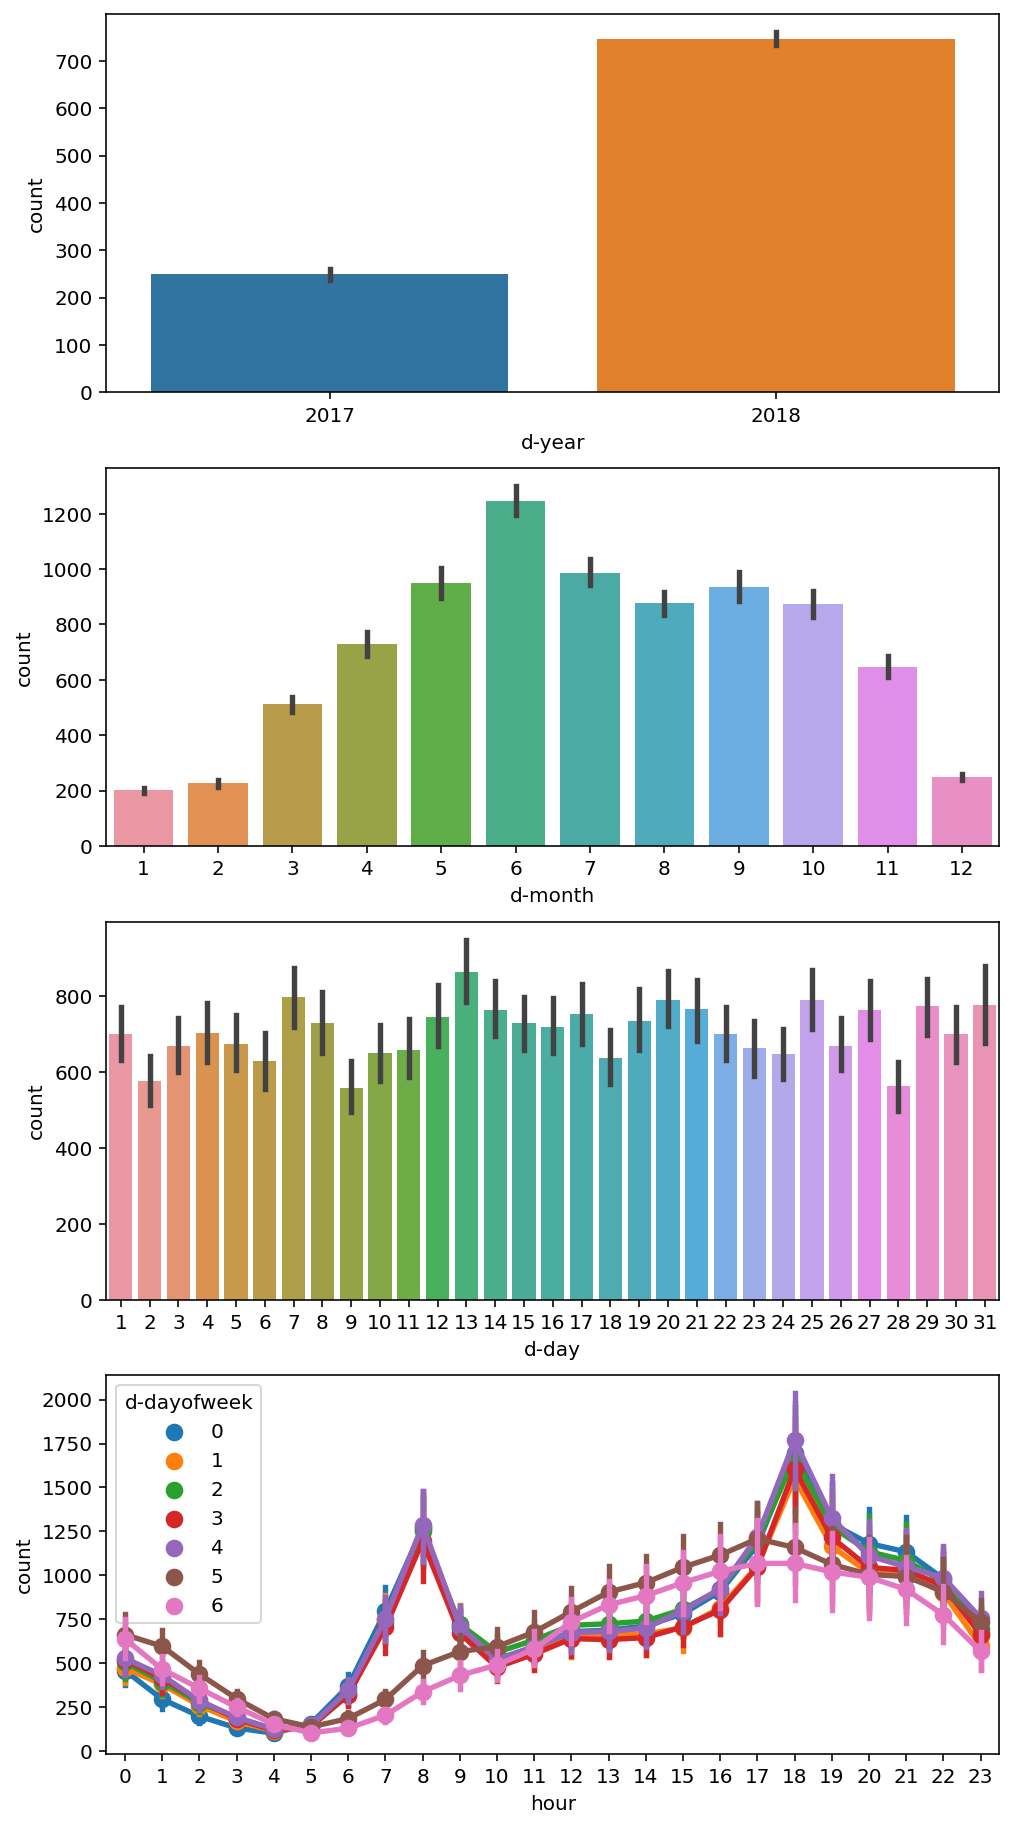

In [14]:
figure, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1,
              figsize=(8,16))
sns.barplot(data=df, x="d-year", y="count", ax=ax1)
sns.barplot(data=df, x="d-month", y="count", ax=ax2)
sns.barplot(data=df, x="d-day", y="count", ax=ax3)
sns.pointplot(data=df, x="hour", y="count", hue="d-dayofweek", ax=ax4)

## 목적변수와 산포도 보기

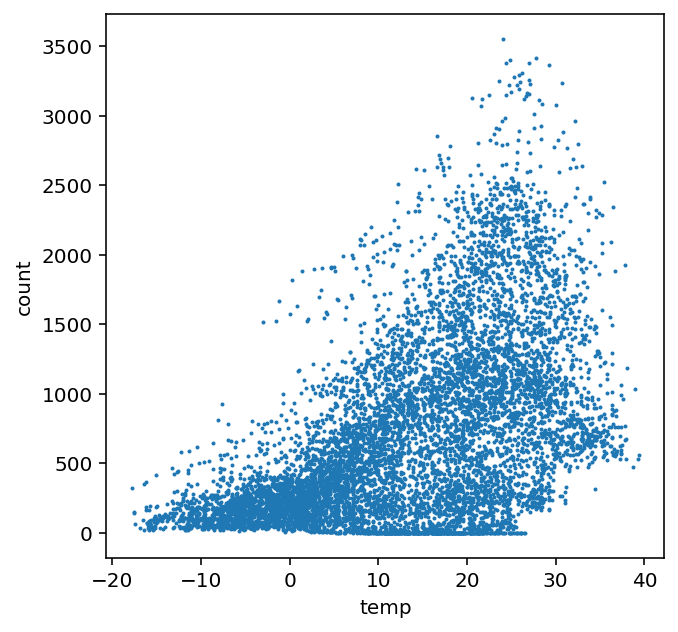

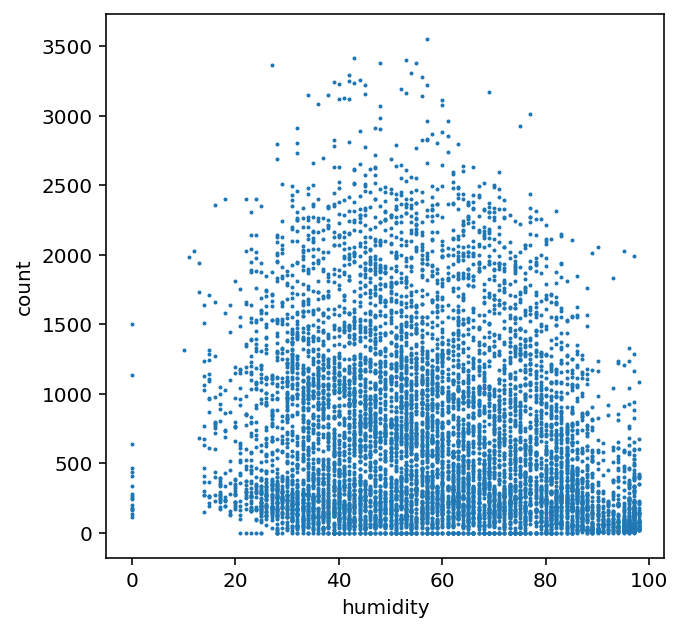

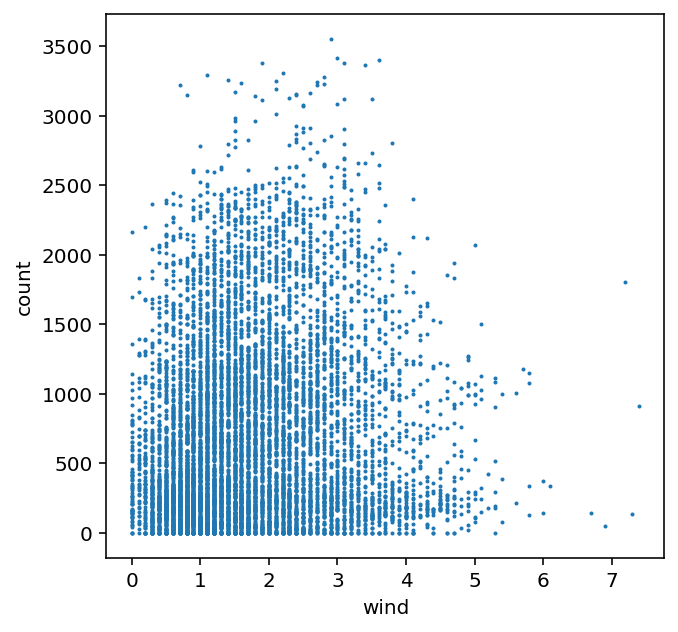

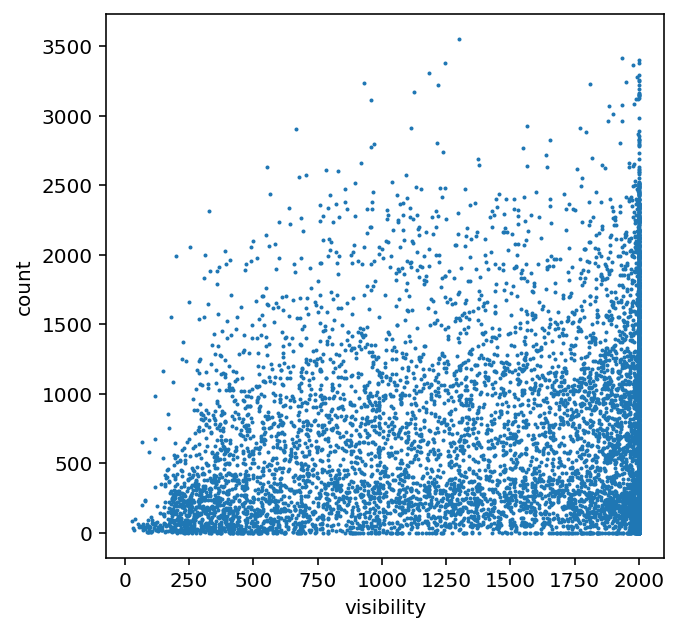

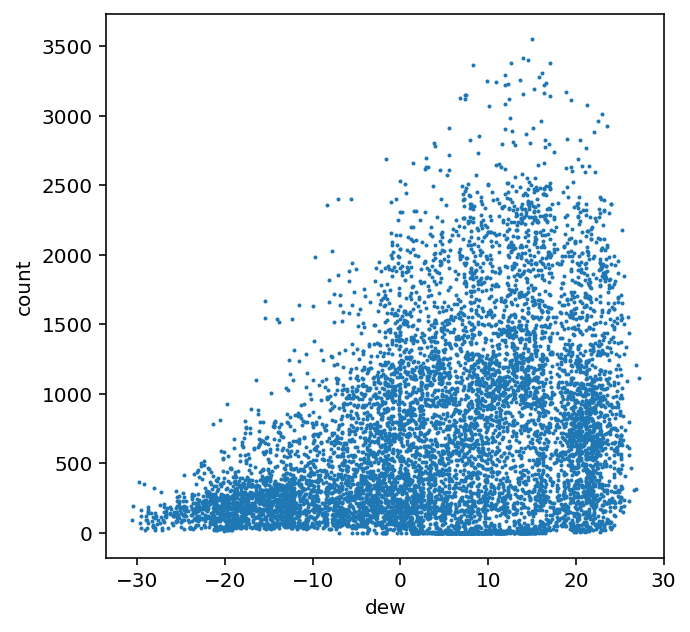

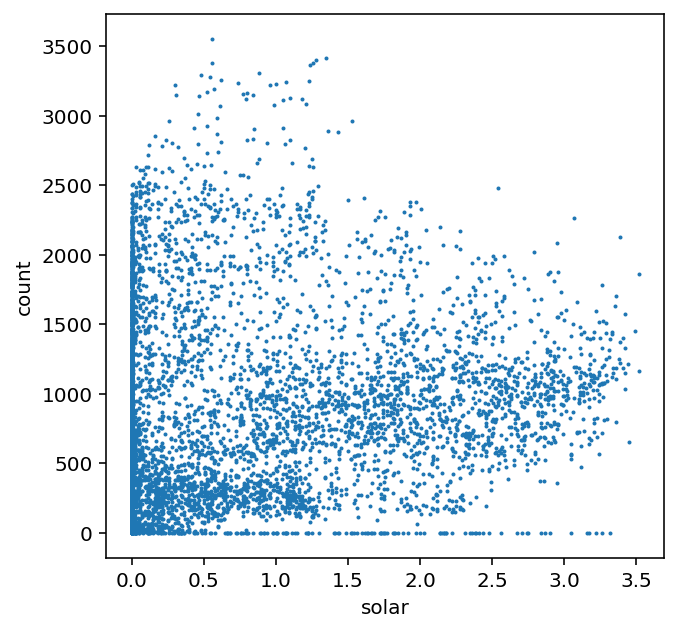

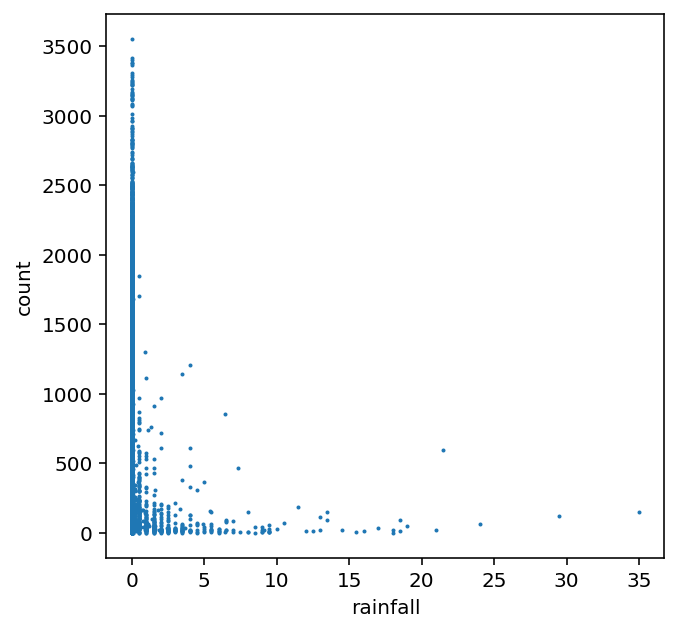

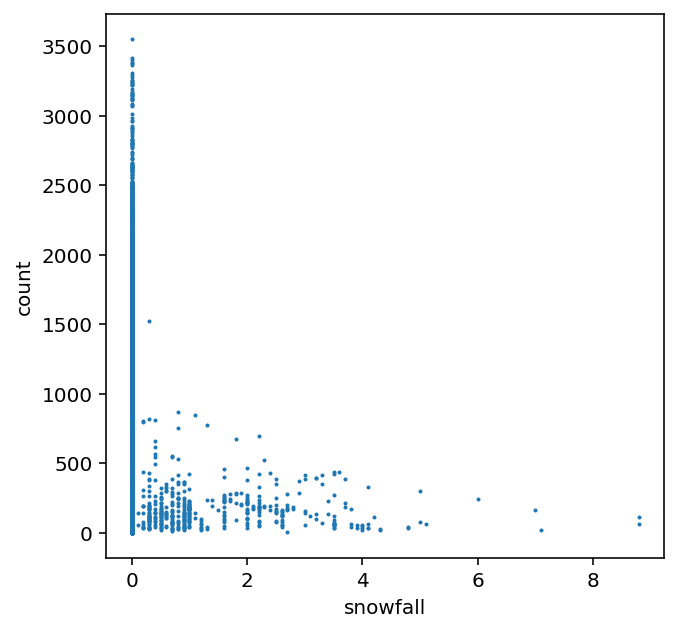

In [15]:
for col in ['temp', 'humidity',
       'wind', 'visibility', 'dew',
       'solar', 'rainfall', 'snowfall']:
    plt.figure(figsize=(5,5))
    plt.scatter(df[col] , df["count"], s=1)
    plt.ylabel('count')
    plt.xlabel(col)
    plt.show()

## 훈련에 사용할 특성 선택

In [16]:
df.columns

Index(['date', 'count', 'hour', 'temp', 'humidity', 'wind', 'visibility',
       'dew', 'solar', 'rainfall', 'snowfall', 'd-year', 'd-month', 'd-day',
       'd-dayofweek', 'seasons_Autumn', 'seasons_Spring', 'seasons_Summer',
       'seasons_Winter', 'holiday_Holiday', 'holiday_No Holiday',
       'functioning_No', 'functioning_Yes'],
      dtype='object')

In [17]:
# 회귀 모델의 성능 보기

def show_reg_result(y_test,y_pred):
    print("Max Error: ", 
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ", 
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ", 
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ", 
      r2_score(y_test, y_pred).round(3))

In [28]:
# 특성별 가중치 (또는 특성 중요도) 보기

def plot_feature_weight(feature, weight):
    plt.figure(figsize=(8,8))
    W = pd.DataFrame({'feature':feature,'weight':weight})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)

## 랜덤 포레스트
- 시계열 데이터로 취급하지 않고 데이터를 셔플링하여 훈련/검증 데이터로 나누겠다 (train_test_split)
- 즉, X-y 모델에서 행단위로 예측을 수행한다 (시간순으로 정렬된 데이터를 사용하지 않는다)

In [19]:
# 사용할 특성 선택  

features = ['hour', 'temp', 'humidity','solar', 'rainfall', 'snowfall', 'd-month',
       'd-day','d-dayofweek', 'seasons_Autumn', 'seasons_Spring', 'seasons_Summer',
       'seasons_Winter', 'holiday_Holiday', 'holiday_No Holiday',
       'functioning_No', 'functioning_Yes']

In [20]:
X = df[features]
X[:3]

,hour,temp,humidity,solar,rainfall,snowfall,d-month,d-dayofweek,seasons_Autumn,seasons_Spring,seasons_Summer,seasons_Winter,holiday_Holiday,holiday_No Holiday,functioning_No,functioning_Yes
0,0,-5.2,37,0.0,0.0,0.0,12,4,0,0,0,1,0,1,0,1
1,1,-5.5,38,0.0,0.0,0.0,12,4,0,0,0,1,0,1,0,1
2,2,-6.0,39,0.0,0.0,0.0,12,4,0,0,0,1,0,1,0,1


In [21]:
# 목적 변수는 자전거 대여수
# X, y를 랜덤하게 나눈다

y = df['count']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [22]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
show_reg_result(y_test,y_pred)

Max Error:  2525.16
Mean Absolute Error:  93.328
Root Mean Squared Error:  167.93
R-Squared:  0.934


### 특성중요도 보기

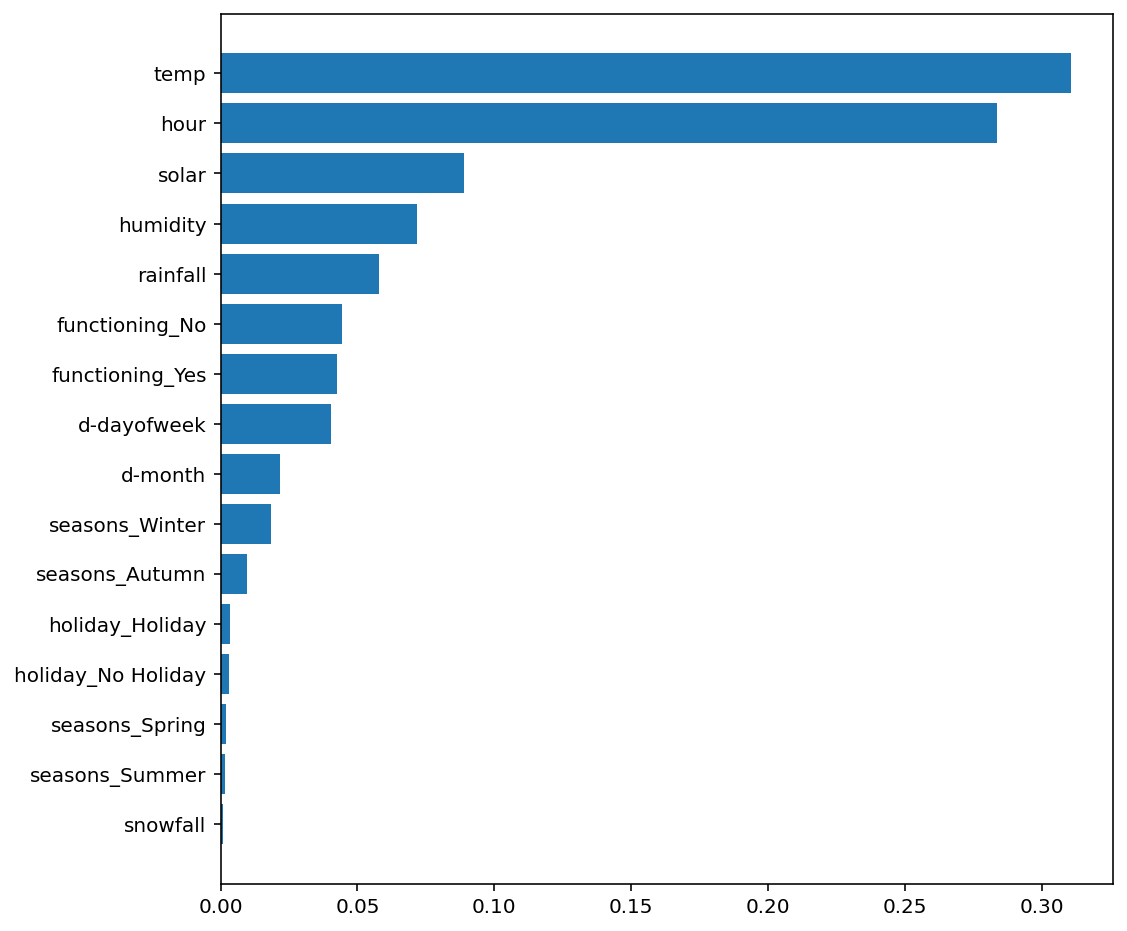

In [29]:
plot_feature_weight(X.columns, model.feature_importances_)

In [30]:
def plot_reg_result(y_test, y_pred, N=50):
    y_test=y_test.ravel()
    y_pred=y_pred.ravel()
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.show()
    plt.title("Residue Plot")
    plt.scatter(y_test, y_test-y_pred, s=5)

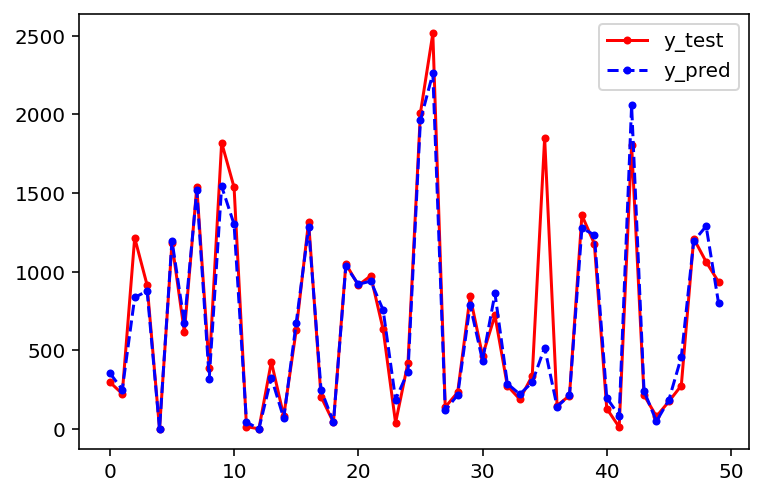

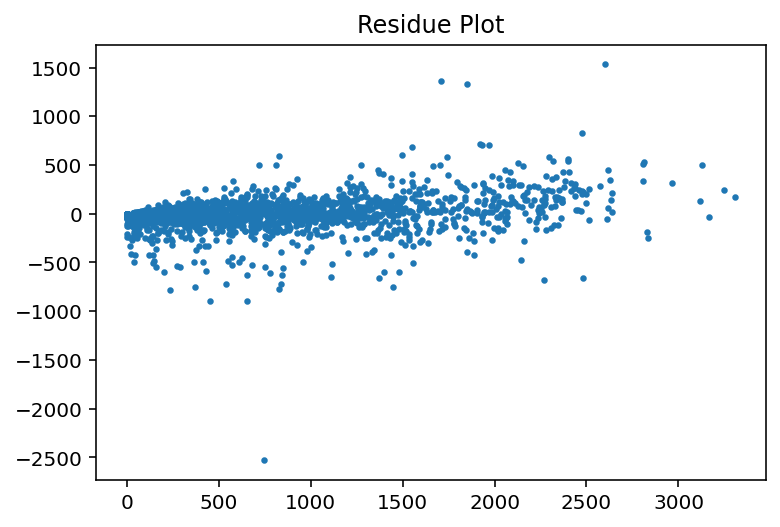

In [32]:
plot_reg_result(y_test, y_pred)

In [33]:
# 실제값과 예측값 비교하기

np.vstack((y_test[:10], y_pred[:10].round(1))).T

array([[ 297. ,  355.2],
       [ 223. ,  249.1],
       [1215. ,  835.2],
       [ 914. ,  876.6],
       [   0. ,    0. ],
       [1180. , 1197.2],
       [ 615. ,  672.6],
       [1536. , 1515.7],
       [ 388. ,  318.9],
       [1820. , 1541.8]])

## LGBMRegressor

In [35]:
lgbm_r = LGBMRegressor()
lgbm_r.fit(X_train, y_train)
y_pred = lgbm_r.predict(X_test)
show_reg_result(y_test,y_pred)

Max Error:  2357.899
Mean Absolute Error:  91.614
Root Mean Squared Error:  158.033
R-Squared:  0.941


## 특성 선택
- 미래 예측할 날짜의 요일, 공휴일, 시간 등을 알 수 있으나 습도, 풍향 등은 미리 알 수가 없다
- 현실적으로 예측 가능한 특성 값만 사용하는 모델을 만들어 본다

In [38]:
# 사용할 특성 선택  

features = ['hour','d-month', 'd-day',
       'd-dayofweek', 'seasons_Autumn', 'seasons_Spring', 'seasons_Summer',
       'seasons_Winter', 'holiday_Holiday', 'holiday_No Holiday',
       'functioning_No', 'functioning_Yes']

In [48]:
# 일부 특성만 사용하면 성능이 떨어진다
# 과거 데이터로만 학습하고 미래를 예측하게 하겠다

X = df[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
lgbm_r.fit(X_train, y_train)
y_pred = lgbm_r.predict(X_test)
show_reg_result(y_test,y_pred)

Max Error:  1946.023
Mean Absolute Error:  301.767
Root Mean Squared Error:  417.717
R-Squared:  0.592


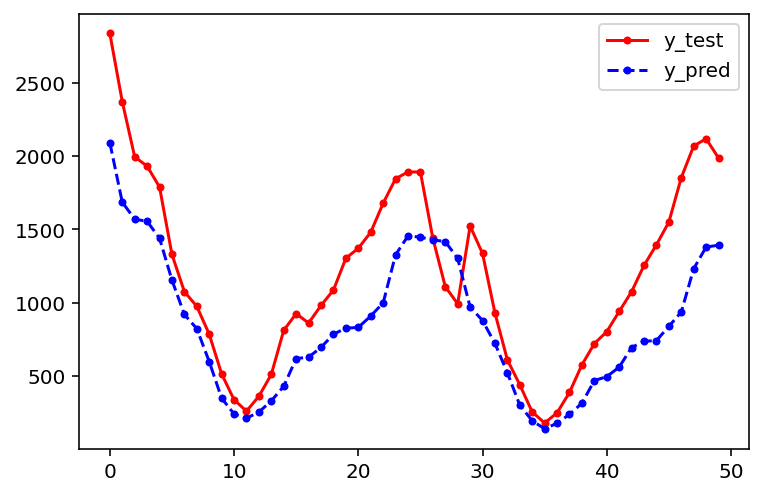

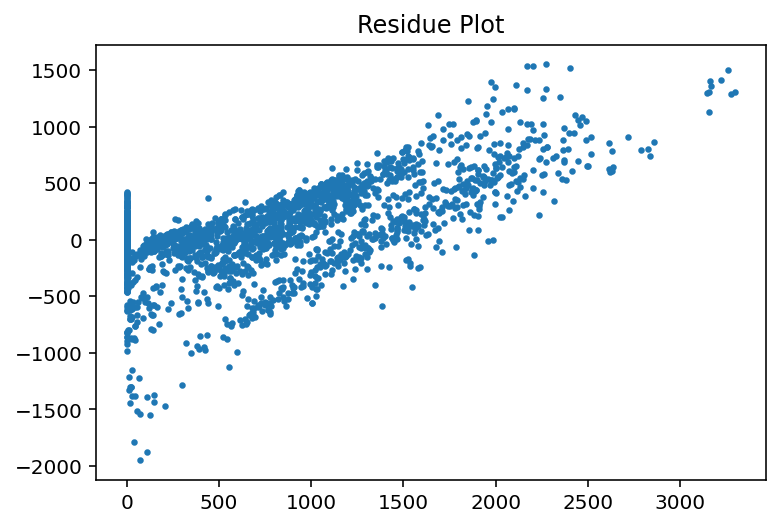

In [49]:
plot_reg_result(y_test,y_pred)

# y-y 모델

- X-y 모델과 y-y 모델의 성능을 비교하겠다

In [40]:
y = df["count"].values
len(y)

8760

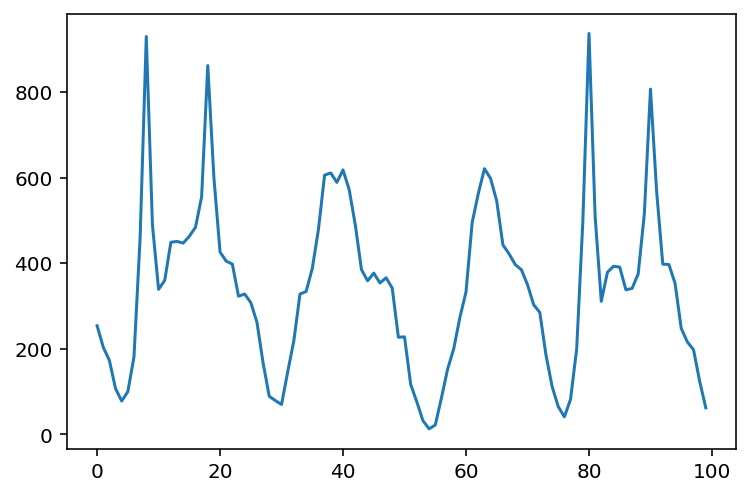

In [41]:
# 시간 단위로 보기
plt.plot(y[:100])

In [50]:
# 앞부분 75%를 훈련 데이터로, 나머지를 검증 데이터로 나누며 시계열 데이터이므로 순서를 유지한다

train_data, test_data = train_test_split(y, shuffle=False)
len(y), len(train_data), len(test_data)

(8760, 6570, 2190)

## 과거 n_steps 샘플로 미래 예측하기

In [51]:
def split_seq(sequence, n_steps):
    x, y = [], []
    for i in range(len(sequence)):
        if i > len(sequence) - (n_steps + 1) : break
        x.append(sequence[i:i+n_steps])
        y.append(sequence[i+n_steps])
    return np.array(x), np.array(y)

In [52]:
# 과거 몇개의 샘플을 예측에 사용할 것인지를 변경하면서 성능을 측정한다

model = LinearRegression()

# 실험 결과를 저장할 리스트
res = []

for n_steps in range(1,300, 3):
    
    # 훈련데이터
    x_train, y_train = split_seq(train_data, n_steps)
    # 검증데이터
    x_test, y_test = split_seq(test_data, n_steps)

    model.fit(x_train, y_train) 
    res.append((n_steps, model.score(x_test, y_test).round(4))) # R2 값

<AxesSubplot:xlabel='time'>

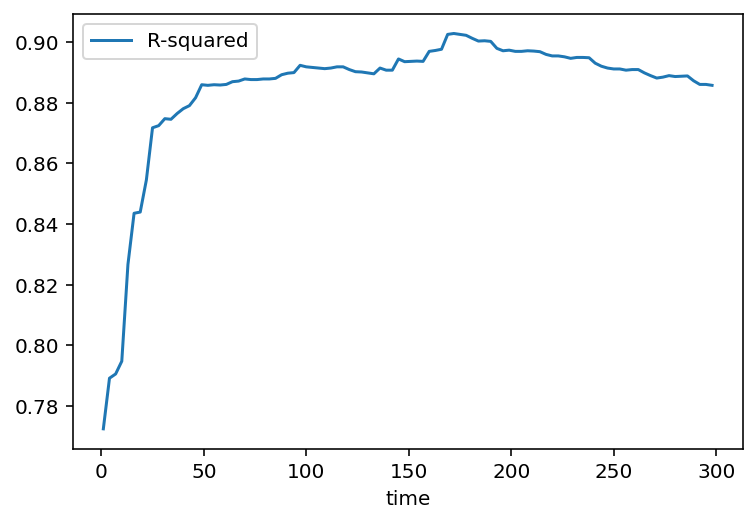

In [53]:
df_r = pd.DataFrame(res, columns=['time','R-squared']).set_index('time')
df_r.plot()

In [54]:
# 최대 성능을 얻는 윈도우 크기

df_r.idxmax(), df_r.max()

(R-squared    172
 dtype: int64,
 R-squared    0.9028
 dtype: float64)

## 먼 미래 예측

- 위의 결과를 보면 y-y 모델이 X-y 모델보다 성능이 좋다
- 이는 y-y 모델이 바로 "한시간 후"를 예측했기 때문이다.
- X-y 모델은 임의의 미래를 예측하므로 성능이 떨어진다
- y-y 모델에서 먼 미래를 예측하는 모델을 만들겠다

In [57]:
# 과거 n_steps_in 개의 샘플을 보고, 먼 미래 값 n_steps_out 후의 값을 예측하기 위한
# 데이터셋를 만드는 함수

def split_seq_2(sequence, n_steps_in, n_steps_out):
  x, y = [],[]
  for i in range(len(sequence)):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    if out_end_ix > len(sequence):
        break
    seq_x, seq_y = sequence[i:end_ix], sequence[out_end_ix-1]
    x.append(seq_x)
    y.append(seq_y)
  return np.array(x), np.array(y)

In [58]:
z = np.arange(15)
split_seq_2(z, 6 ,2)

(array([[ 0,  1,  2,  3,  4,  5],
        [ 1,  2,  3,  4,  5,  6],
        [ 2,  3,  4,  5,  6,  7],
        [ 3,  4,  5,  6,  7,  8],
        [ 4,  5,  6,  7,  8,  9],
        [ 5,  6,  7,  8,  9, 10],
        [ 6,  7,  8,  9, 10, 11],
        [ 7,  8,  9, 10, 11, 12]]),
 array([ 7,  8,  9, 10, 11, 12, 13, 14]))

In [59]:
# 먼 미래 예측 1~72 시간 후를 예측해보겠다

n_steps = 172

res = []
for n_future in range(1,73, 2):

    x_train, y_train = split_seq_2(train_data, n_steps, n_future)
    x_test, y_test = split_seq_2(test_data, n_steps, n_future)
    model.fit(x_train, y_train) 
    res.append((n_future, model.score(x_test, y_test).round(4))) # R2 값

<AxesSubplot:xlabel='time'>

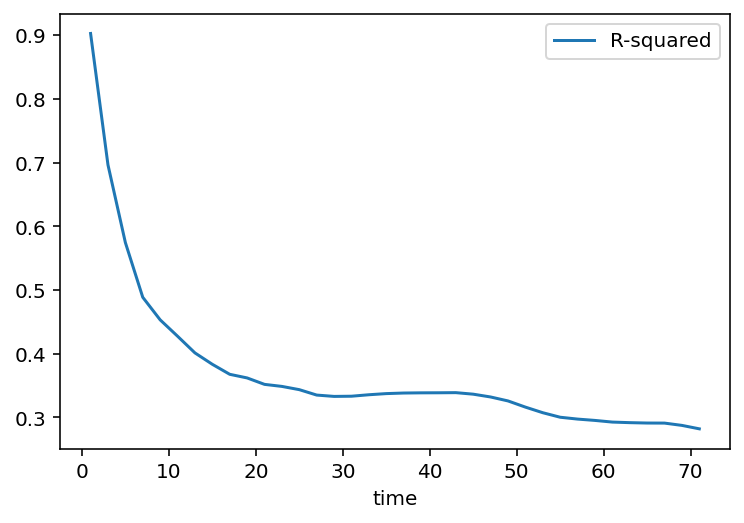

In [60]:
df_r = pd.DataFrame(res, columns=['time','R-squared']).set_index('time')
df_r.plot()

- 위 결과를 보면 먼 미래를 예측하면 성능이 떨어진다